In [1]:
!python --version

Python 3.13.7


In [2]:
from google import genai
from dotenv import load_dotenv
import os

load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY", "")
client = genai.Client(api_key=GEMINI_API_KEY)

response = client.models.generate_content(
    model="gemini-2.5-flash", contents="Explain how AI works in a few words"
)

print(response.text)

AI enables machines to **learn from data**, identify patterns, and make decisions or predictions.


In [3]:
import json

with open(r"c:\Auto\HCI-Summarize_agent\scrape_news\23092025.json", "r", encoding="utf-8") as f:
    news = json.load(f)

print(list(news.keys()))

['Nvidia', 'AMD', 'Intel']


In [4]:
from datetime import datetime
import re

chipmakers = list(news.keys())
chipmaker = chipmakers[0]

nvidia_news = news[chipmaker]
print(f"Number of news articles about {chipmaker}:", len(nvidia_news))

date_news = list(set([article['scraped_date'] for article in nvidia_news]))
date_news = sorted(date_news, key=lambda d: datetime.strptime(d, "%Y-%m-%d"), reverse=True)
dict_date_news = {date: "" for date in date_news}

# Process articles by date
for date in date_news:
    articles_for_date = []
    
    # Collect all descriptions for this date
    for article in nvidia_news:
        if article['scraped_date'] == date:
            description = article.get('description')
            if description is not None:
                articles_for_date.append(description)
    
    # Clean and join the descriptions
    if articles_for_date:
        cleaned_descriptions = []
        for desc in articles_for_date:
            cleaned_desc = re.sub(r'\s+', ' ', desc).strip()
            if cleaned_desc: 
                cleaned_descriptions.append(cleaned_desc)
        
        text = "\n".join(cleaned_descriptions)
        dict_date_news[date] = text
        print(f"{date}: {len(cleaned_descriptions)} articles with valid descriptions")
    else:
        print(f"{date}: 0 articles with valid descriptions")

Number of news articles about Nvidia: 94
2025-09-22: 14 articles with valid descriptions
2025-09-21: 11 articles with valid descriptions
2025-09-20: 13 articles with valid descriptions
2025-09-19: 12 articles with valid descriptions
2025-09-18: 16 articles with valid descriptions
2025-09-17: 11 articles with valid descriptions
2025-09-16: 10 articles with valid descriptions


In [5]:
dict_date_news

{'2025-09-22': 'OpenAI is teaming up with Nvidia via a “strategic partnership” that will get the ChatGPT-maker more compute and more cash to develop new models on the road to superintelligence. The partnership, announced Monday, will allow OpenAI to “build and deploy at leas…\nNvidia will invest up to $100 billion in OpenAI as the AI lab builds data centers requiring 10 gigawatts of power capacity. The 10-gigawatt deployment equals 4 to 5 million GPUs -- the same number Nvidia will ship globally this year. Building one gigawatt of …\nThe two tech titans announced a deal on Monday that will see OpenAI build out "at least 10 gigawatts" of AI data centers running Nvidia systems.\n$100 billion is worth something like 333 AI researchers with Meta salaries.\nWhen people talk about artificial intelligence stocks, they usually think of chip companies like Nvidia (NVDA) or companies working on large language models,...\nShares of server solutions provider Super Micro (NASDAQ:SMCI) jumped 3% in 

In [15]:
from typing import Optional
from pydantic import BaseModel

class Relation(BaseModel):
    verb: str
    detail: Optional[str] = None

class Triplet(BaseModel):
    subject: str
    relation: Relation
    object: str

triplet_schema = {
    "type": "ARRAY",
    "items": {
        "type": "OBJECT",
        "properties": {
            "subject": {"type": "STRING"},
            "relation": {
                "type": "OBJECT",
                "properties": {
                    "verb": {"type": "STRING"},
                    "detail": {"type": "STRING"},  # keep STRING
                },
                "required": ["verb"]
            },
            "object": {"type": "STRING"}
        },
        "required": ["subject", "relation", "object"]
    }
}


extract_prompt = """
You are an information extraction system. Read the news articles and extract factual triplets.

CONTEXT:
- Focus only on **{chipmaker}**
- Ignore information not directly related to {chipmaker}.
- Do not add opinions, speculation, or commentary.

TASK:
- Convert the news summary into a list of triplets following the Triplet schema.

Triplet schema (Python syntax):
[
  {{
    "subject": "<one word entity>",
    "relation": {{
      "verb": "<simple present tense verb>",
      "detail": "<concise relation detail or None>"
    }},
    "object": "<one word entity>"
  }}
]

RULES:
- Use simple present tense verbs only (e.g., "acquire", "announce", "invest").
- Subject and object must be specific entities expressed in **one word** (company, person, place, or date).
- If detail exists (amount, date, location, extra context), put it in `relation.detail`.
- Preserve important entities (companies, people, places, dates).
- Avoid redundancy, trivial details, and long phrases.
- The output must be valid Python syntax (a list of Triplet dictionaries).
- Extract only triplets about **{chipmaker}**.

ARTICLES:
{articles}
"""

In [16]:
from tqdm import tqdm

def clean_text(text: str | None) -> str:
    if not text:
        return ""
    return re.sub(r"\s+", " ", text).strip()

def group_articles_by_date(articles: list[dict]) -> dict[str, str]:
    grouped = {}
    for article in articles:
        date = article.get("scraped_date")
        desc = clean_text(article.get("description"))

        # Skip if missing
        if not date or not desc:
            continue

        grouped.setdefault(date, []).append(desc)

    # Join all descriptions per date
    return {
        date: "\n".join(descs)
        for date, descs in grouped.items()
    }

def extract_triplets(chipmaker: str, articles: str) -> list[Triplet]:
    """Call Gemini to extract triplets."""
    if not articles.strip():
        return []

    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=extract_prompt.format(
            chipmaker=chipmaker,
            articles=articles,
        ),
        config={
            "response_mime_type": "application/json",
            "response_schema": triplet_schema, 
        },
    )

    return [Triplet(**t) for t in response.parsed]

def process_news(news: dict[str, list[dict]]) -> dict[str, list[dict]]:
    """Process all chipmakers and return structured triplets by date."""
    result = {}
    for chipmaker, articles in news.items():
        print(f"\n🔎 Processing chipmaker: {chipmaker}")
        print(f"Number of news articles: {len(articles)}")

        # Group articles by date
        dict_date_news = group_articles_by_date(articles)

        # Sort dates (skip invalid ones)
        try:
            date_news = sorted(
                dict_date_news.keys(),
                key=lambda d: datetime.strptime(d, "%Y-%m-%d"),
                reverse=True,
            )
        except ValueError:
            # Skip invalid dates
            date_news = [
                d for d in dict_date_news.keys()
                if re.match(r"^\d{4}-\d{2}-\d{2}$", d)
            ]
            date_news = sorted(
                date_news,
                key=lambda d: datetime.strptime(d, "%Y-%m-%d"),
                reverse=True,
            )

        result[chipmaker] = []
        for date in tqdm(date_news, desc=f"Processing {chipmaker}"):
            article_text = dict_date_news[date]
            print(f"{date}: {article_text.count('\\n')+1 if article_text else 0} articles with valid descriptions")

            triplets = extract_triplets(chipmaker, article_text)
            result[chipmaker].append({"date": date, "triplets": triplets})

    return result

result = process_news(news)


🔎 Processing chipmaker: Nvidia
Number of news articles: 94


Processing Nvidia:   0%|          | 0/7 [00:00<?, ?it/s]

2025-09-22: 1 articles with valid descriptions


Processing Nvidia:  14%|█▍        | 1/7 [00:30<03:03, 30.58s/it]

2025-09-21: 1 articles with valid descriptions


Processing Nvidia:  29%|██▊       | 2/7 [00:45<01:46, 21.37s/it]

2025-09-20: 1 articles with valid descriptions


Processing Nvidia:  43%|████▎     | 3/7 [01:22<01:53, 28.37s/it]

2025-09-19: 1 articles with valid descriptions


Processing Nvidia:  57%|█████▋    | 4/7 [02:00<01:37, 32.43s/it]

2025-09-18: 1 articles with valid descriptions


Processing Nvidia:  71%|███████▏  | 5/7 [02:28<01:01, 30.63s/it]

2025-09-17: 1 articles with valid descriptions


Processing Nvidia:  86%|████████▌ | 6/7 [02:46<00:26, 26.49s/it]

2025-09-16: 1 articles with valid descriptions


Processing Nvidia: 100%|██████████| 7/7 [03:01<00:00, 25.89s/it]



🔎 Processing chipmaker: AMD
Number of news articles: 65


Processing AMD:   0%|          | 0/7 [00:00<?, ?it/s]

2025-09-22: 1 articles with valid descriptions


Processing AMD:  14%|█▍        | 1/7 [00:21<02:06, 21.12s/it]

2025-09-21: 1 articles with valid descriptions


Processing AMD:  29%|██▊       | 2/7 [00:49<02:07, 25.55s/it]

2025-09-20: 1 articles with valid descriptions


Processing AMD:  43%|████▎     | 3/7 [01:09<01:32, 23.06s/it]

2025-09-19: 1 articles with valid descriptions


Processing AMD:  57%|█████▋    | 4/7 [01:28<01:04, 21.37s/it]

2025-09-18: 1 articles with valid descriptions


Processing AMD:  71%|███████▏  | 5/7 [02:01<00:51, 25.56s/it]

2025-09-17: 1 articles with valid descriptions


Processing AMD:  86%|████████▌ | 6/7 [02:34<00:27, 27.95s/it]

2025-09-16: 1 articles with valid descriptions


Processing AMD: 100%|██████████| 7/7 [02:44<00:00, 23.55s/it]



🔎 Processing chipmaker: Intel
Number of news articles: 79


Processing Intel:   0%|          | 0/7 [00:00<?, ?it/s]

2025-09-22: 1 articles with valid descriptions


Processing Intel:  14%|█▍        | 1/7 [00:29<02:57, 29.54s/it]

2025-09-21: 1 articles with valid descriptions


Processing Intel:  29%|██▊       | 2/7 [00:43<01:43, 20.63s/it]

2025-09-20: 1 articles with valid descriptions


Processing Intel:  43%|████▎     | 3/7 [01:12<01:36, 24.23s/it]

2025-09-19: 1 articles with valid descriptions


Processing Intel:  57%|█████▋    | 4/7 [01:48<01:27, 29.09s/it]

2025-09-18: 1 articles with valid descriptions


Processing Intel:  71%|███████▏  | 5/7 [02:32<01:08, 34.35s/it]

2025-09-17: 1 articles with valid descriptions


Processing Intel:  86%|████████▌ | 6/7 [02:37<00:24, 24.45s/it]

2025-09-16: 1 articles with valid descriptions


Processing Intel: 100%|██████████| 7/7 [03:19<00:00, 28.50s/it]


In [17]:
result['Nvidia'][6]['triplets']

[Triplet(subject='China', relation=Relation(verb='scrutinizes', detail=None), object='Nvidia'),
 Triplet(subject='Tencent', relation=Relation(verb='breaks', detail=None), object='Nvidia'),
 Triplet(subject='Nvidia', relation=Relation(verb='uses', detail='A16 process'), object='TSMC'),
 Triplet(subject='JPMorgan', relation=Relation(verb='reaffirms', detail='Overweight rating'), object='Nvidia'),
 Triplet(subject='Nvidia', relation=Relation(verb='struggles', detail='to sell RTX6000D'), object='GPUs'),
 Triplet(subject='Nvidia', relation=Relation(verb='exports', detail='to China'), object='chips')]

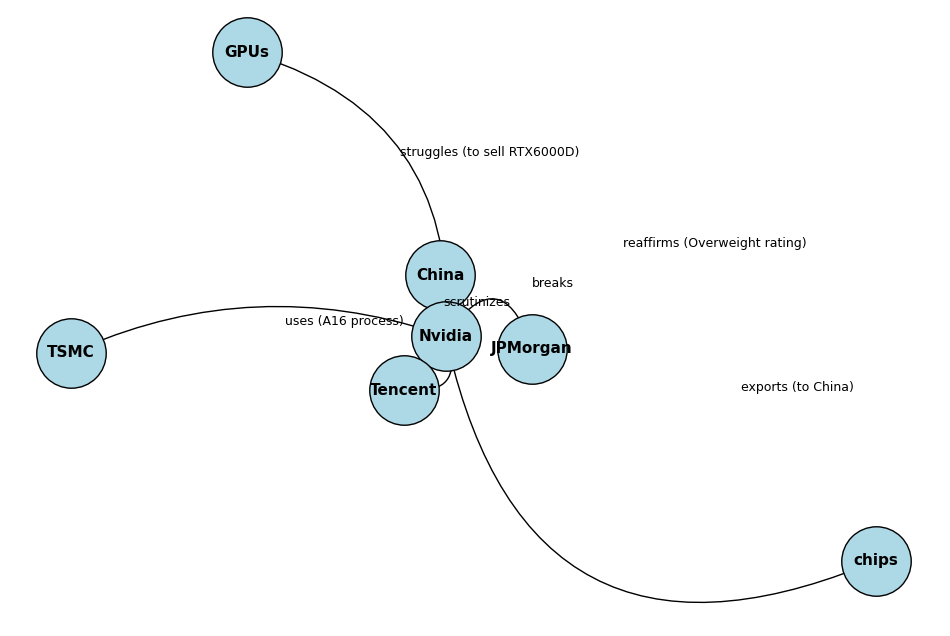

In [31]:
import networkx as nx
import matplotlib.pyplot as plt

# Use MultiDiGraph to keep direction + multiple edges
G = nx.MultiDiGraph()

# Add triplets
for t in result['Nvidia'][6]['triplets']:
    subj, obj = t.subject, t.object
    verb, detail = t.relation.verb, t.relation.detail

    # Build relation label
    rel_label = f"{verb} ({detail})" if detail else verb

    # Add edge with unique key
    G.add_edge(subj, obj, label=rel_label)

# Layout
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 8))

# Nodes
nx.draw_networkx_nodes(G, pos, node_size=2500, node_color="lightblue", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold")

# Draw multiple edges with curvature
for i, (u, v, key, data) in enumerate(G.edges(keys=True, data=True)):
    # vary curvature by edge index between nodes
    rad = 0.2 * (i - (len(G[u][v]) - 1) / 2)
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        connectionstyle=f"arc3,rad={rad}",
        arrowstyle="->", arrowsize=20
    )
    # edge label at midpoint
    x = (pos[u][0] + pos[v][0]) / 2
    y = (pos[u][1] + pos[v][1]) / 2
    plt.text(x + rad*0.3, y + rad*0.3, data["label"], fontsize=9, color="black")

plt.axis("off")
plt.show()

In [25]:
result['Nvidia'][0]['triplets']

[Triplet(subject='Nvidia', relation=Relation(verb='partners', detail='strategic'), object='OpenAI'),
 Triplet(subject='Nvidia', relation=Relation(verb='invests', detail='$100 billion'), object='OpenAI'),
 Triplet(subject='Nvidia', relation=Relation(verb='ships', detail='4-5 million globally'), object='GPUs'),
 Triplet(subject='Nvidia', relation=Relation(verb='provides', detail='for OpenAI data centers'), object='systems'),
 Triplet(subject='Nvidia', relation=Relation(verb='provides', detail='for OpenAI data centers'), object='chips'),
 Triplet(subject='Nvidia', relation=Relation(verb='keeps', detail='central to AI systems'), object='hardware'),
 Triplet(subject='Nvidia', relation=Relation(verb='partners', detail='historic deal'), object='Intel'),
 Triplet(subject='Nvidia', relation=Relation(verb='invests', detail='$5 billion'), object='Intel'),
 Triplet(subject='Nvidia', relation=Relation(verb='provides', detail='millions for OpenAI'), object='GPUs')]

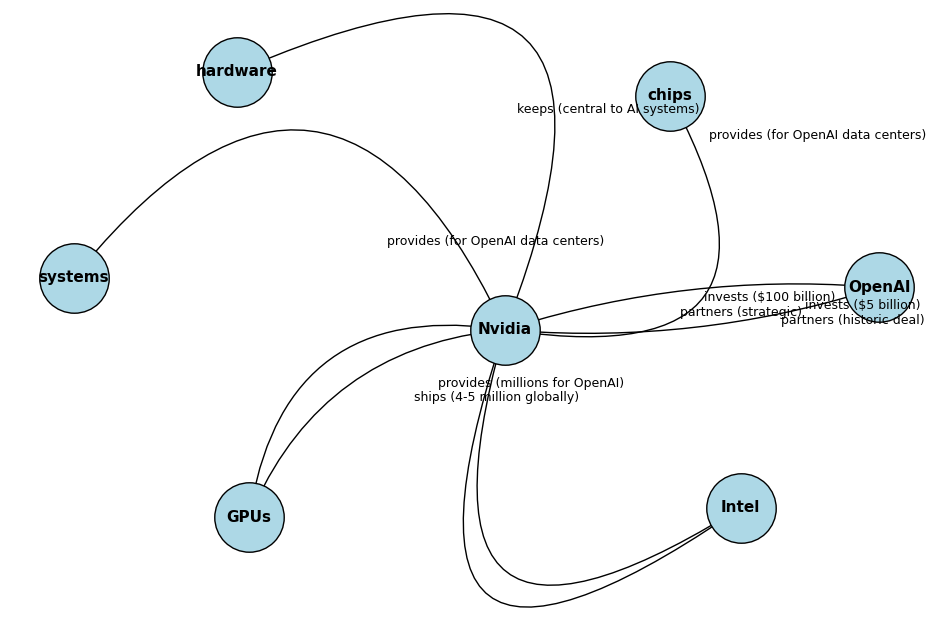

In [32]:
G = nx.MultiDiGraph()

# Add triplets
for t in result['Nvidia'][0]['triplets']:
    subj, obj = t.subject, t.object
    verb, detail = t.relation.verb, t.relation.detail

    # Build relation label
    rel_label = f"{verb} ({detail})" if detail else verb

    # Add edge with unique key
    G.add_edge(subj, obj, label=rel_label)

# Layout
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 8))

# Nodes
nx.draw_networkx_nodes(G, pos, node_size=2500, node_color="lightblue", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold")

# Draw multiple edges with curvature
for i, (u, v, key, data) in enumerate(G.edges(keys=True, data=True)):
    # vary curvature by edge index between nodes
    rad = 0.2 * (i - (len(G[u][v]) - 1) / 2)
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        connectionstyle=f"arc3,rad={rad}",
        arrowstyle="->", arrowsize=20
    )
    # edge label at midpoint
    x = (pos[u][0] + pos[v][0]) / 2
    y = (pos[u][1] + pos[v][1]) / 2
    plt.text(x + rad*0.3, y + rad*0.3, data["label"], fontsize=9, color="black")

plt.axis("off")
plt.show()

In [33]:
import json

serializable_result = {
    chip: [
        {
            "date": entry["date"],
            "triplets": [
                {
                    "subject": t.subject,
                    "relation": {
                        "verb": t.relation.verb,
                        "detail": t.relation.detail
                    },
                    "object": t.object
                }
                for t in entry["triplets"]
            ]
        }
        for entry in entries
    ]
    for chip, entries in result.items()
}

with open("23092025_graph.json", mode="w", encoding="utf-8") as f:
    json.dump(serializable_result, f, ensure_ascii=False, indent=2)